In [1]:
import warnings
import pytorch_lightning as pl
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.callbacks.early_stopping import EarlyStopping

from mpvn.data.grad.lit_data_module import LightningGradDataModule
from mpvn.metric import WordErrorRate, CharacterErrorRate
from mpvn.model.model import *

from mpvn.configs import DictConfig

/home/wicii/miniconda3/envs/grad/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/wicii/miniconda3/envs/grad/lib/python3.8/site-packages/pkg_resources/__init__.py:123: PkgResourcesDeprecationWarning: latest is an invalid version and will not be supported in a future release
  warnings.warn(


In [2]:
checkpoint_callback = ModelCheckpoint(
    save_top_k=3,
    monitor="valid_loss",
    mode="min",
    dirpath="checkpoint",
    filename="mpvn-{epoch:02d}-{valid_loss:.2f}-{valid_per:.2f}-{valid_acc}",
)
early_stop_callback = EarlyStopping(
    monitor="valid_loss", 
    min_delta=0.00, 
    patience=5, 
    verbose=False, 
    mode="min"
)
logger = TensorBoardLogger("tensorboard", name="Pronunciation for Vietnamese")

In [3]:
configs = DictConfig()

# pl.seed_everything(configs.seed)
warnings.filterwarnings('ignore')

data_module = LightningGradDataModule(configs)
vocab = data_module.get_vocab() 

trainer = pl.Trainer(accelerator='cpu',
                      gpus=0,
                      logger=logger,
                      max_epochs=configs.max_epochs,
                      callbacks=[checkpoint_callback, early_stop_callback])

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [4]:
model = ConformerRNNModel.load_from_checkpoint(
    'Checkpoint/finetuned-epoch=24-valid_loss=0.14-valid_per=0.47-valid_acc=0.93-valid_f1=0.68.ckpt',
    configs=configs,
    num_classes=len(vocab),
    vocab=vocab,
    per_metric=WordErrorRate(vocab)
)


  | Name         | Type             | Params
--------------------------------------------------
0 | criterion    | JointLoss        | 0     
1 | encoder      | ConformerEncoder | 2.6 M 
2 | decoder      | RNNDecoder       | 267 K 
3 | word_decoder | WordDecoder      | 282 K 
--------------------------------------------------
3.2 M     Trainable params
0         Non-trainable params
3.2 M     Total params
12.710    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]Data/vivos/test/waves/VIVOSDEV03/VIVOSDEV03_T035.wav 0.08359289169311523
Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]Data/vivos/test/waves/VIVOSDEV05/VIVOSDEV05_295.wav 0.11776208877563477
Data/vivos/test/waves/VIVOSDEV02/VIVOSDEV02_R122.wav 0.09900951385498047

Result of vivosdev03_t035
EP: torch.Size([57]) ________mɛ6--əːəːj-kɔɜ-m--_ɗə2w-tʃɔ-kaan-xoŋ________<e><e><e><e><e><e><e><e>
PR: torch.Size([26]) mɛ6-əːj-kɔɜ-muə-ɗə2-tʃɔ-kɔn-xoŋ<e>
Ro: torch.Size([26]) mɛ6-əːj-kɔɜ-muə-ɗo2-tʃɔ-kɔn-xoŋ<e>
Rc: torch.Size([26]) miɛ1-əːj-lɔɜ-məɪ2-so2-ze2-kɔn-boŋ<e>
Per: 0.05263157894736842
MED output   : tensor([0, 1, 0, 0, 0, 0, 1, 0])
Score        : tensor([0, 1, 0, 0, 0, 0, 1, 0])
Accuracy: 1.0
Decoder-Encoder Attention: torch.Size([26, 57])


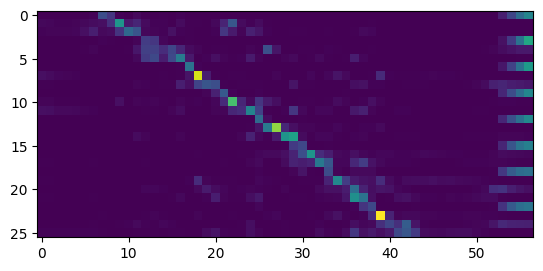

                                                                           Data/vivos/test/waves/VIVOSDEV08/VIVOSDEV08_053.wav 0.08449625968933105
Epoch 0:   0%|          | 0/46255 [00:00<?, ?it/s] Data/vlsp2020_speaker/speaker/speaker_186-080224-1.wav 0.07180213928222656
Data/inforeTTS/wavs/1/3/13163.wav 1.719761610031128
Data/inforeTTS/wavs/1/3/13369.wav 0.5633683204650879
Data/vivos/train/waves/VIVOSSPK35/VIVOSSPK35_071.wav 0.11280059814453125


NameError: name 'exit' is not defined

In [5]:
trainer.fit(model, data_module)

Validation DataLoader 0:   0%|          | 0/50 [00:00<?, ?it/s]
Result of vivosdev12_213
EP: torch.Size([70]) ________________baː2w-mej-haːjj---b_aː--myəj-baː______________<e><e><e><e><e><e><e><e><e>
PR: torch.Size([21]) baː2wmej-haːj-baː-myəj-baː<e>
Ro: torch.Size([21]) baː-myəj-haːj-baː-myəj-baː<e>
Rc: torch.Size([21]) baː-myəj-hu4j-bəɪ6-tʃyəp-baː<e>
Per: 0.1875
MED output   : tensor([1, 1, 0, 0, 0, 1])
Score        : tensor([1, 1, 0, 0, 0, 1])
Accuracy: 1.0
Decoder-Encoder Attention: torch.Size([21, 70])


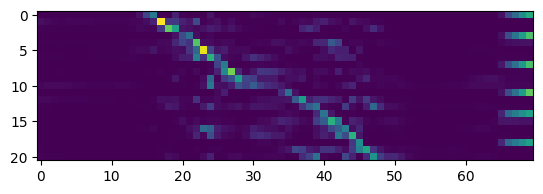

Validation DataLoader 0: 100%|██████████| 50/50 [00:07<00:00,  6.88it/s]

2023-02-28 23:03:11.464184: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-28 23:03:12.857385: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-02-28 23:03:12.857442: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-02-28 23:03:13.052241: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-02-28 23:03:16.118463: W tensorflow/stream_executor/platform/de

Validation DataLoader 0: 100%|██████████| 50/50 [00:15<00:00,  3.33it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        valid_acc           0.8117131757131755
        valid_f1            0.8256608767087295
       valid_loss           0.5651592016220093
        valid_per           0.16256242990493774
     valid_precision        0.7599438894438896
      valid_recall           0.939420634920635
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'valid_loss': 0.5651592016220093,
  'valid_per': 0.16256242990493774,
  'valid_acc': 0.8117131757131755,
  'valid_f1': 0.8256608767087295,
  'valid_precision': 0.7599438894438896,
  'valid_recall': 0.939420634920635}]

In [ ]:
trainer.validate(model, data_module)